[./lecture-05.ipynb](./lecture-05.ipynb)

First a mini-review. We started with mole balances in systems that have constant volume or constant volumetric flow. In those systems we have $C_j = F_j / \nu$. Then, we considered for gas systems that have a changing number of moles that the volumetric flow changes, and then we derived an equation: $\nu = \nu_0 \frac{F_T}{F_{T0}}$ at constant pressure and temperature. In the next example we will consider a system with a changing volume, and we use it to compute the concentration as $C_j(t) = N_j(t) / V(t)$. After that, we will consider reactors with pressure drops which also modifies the volumetric flow.


# Semi-batch reactor

A semi-batch reactor is in between a batch reactor and a CSTR. A typical operation is that the reactor is initially full of one reactant, and one adds the second reactant slowly. There is usually no outlet flow, so the volume of the reactor is not constant. It is a transient reactor. 
Semibatch reactors are most often used when there are multiple reactions present, and it is advantageous to control the rate by slowly adding one reactant.

![img](https://raw.githubusercontent.com/jkitchin/s17-06364/master/lectures/images/semibatch.png)

The main reason to use a semi-batch reactor is to control reaction rate by slowly adding reactants in the feed stream. Assuming that $B$ is the species fed to the reactor, a mole balance on species $B$ becomes:

$\frac{d(N_B)}{dt} = \nu C_B + r_B V$

All other species mole balances are the same as the batch reactor *except* that we need to account for the changing volume on the concentrations in the rate laws.

Note, we need an equation for how the volume changes now too. If the density is not a function of composition, we have $V = V_0 + \nu_0 t$, or alternatively: $\frac{dV}{dt} = \nu_0$.

Let us consider an example of $A + B \rightarrow C$. We start with 5 L of $A$ at a concentration of 2 mol/L in a 10 L reactor.  We add $B$ at a rate of $0.1 L / min$ at a concentration of 2 mol/L. The rate law is given as $r = k C_A C_B^2$ with $k = 0.02$ L<sup>2</sup>/mol<sup>2</sup>/hr. Find the concentration of A when the reactor is full.

The mole balance on $A$ is $\frac{d N_A}{dt} = r_A V$ with $N_A(t=0) = V_0 C_{A0}$.

On $B$ we have $\frac{d N_B}{dt} = v_0 C_{B0} + r_B  V$ with $N_B(t=0) = 0$.

Assuming no change in density we have $\frac{dV}{dt} = v_0$ with $V(t=0) = 5$ L, we only have 5 L of available volume, which will take 50 minutes to fill at 0.1 L/min.

So we have to compute the final concentrations of A and B after 50 minutes.

First, we import and define variables.



In [1]:
import numpy as np
from scipy.integrate import odeint

k = 0.02      # L^2/mol^2/hr

Ca0 = 2.0     # mol / L
Cbfeed = 2.0  # mol /L

v0 = 0.1      # L / min
V0 = 5.0      # L

Now we define our ODEs. There are three. We also evaluate it at the initial conditions.



In [11]:
# We have three ODEs
def ode(Y, t):
    Na, Nb, V = Y

    Ca = Na / V
    Cb = Nb / V
    r = k * Ca * Cb**2

    ra = -r
    rb = -r

    dNadt = ra * V
    dNbdt = v0 * Cbfeed + rb * V
    dVdt = v0
    return [dNadt, dNbdt, dVdt]

print(ode([Ca0 * V0, 0, V0], t=0))

[-0.0, 0.2, 0.1]


You can see from this that at t=0, the rate of change of concentration of A is zero (the negative sign does not mean anything here. Technically A is getting diluted and the concentration of A is decreasing.). Species B is increasing because we are adding it to the reactor. And the volume is increasing.

Note this behavior:



In [6]:
print(0.0 * -1)  # float multiplication
print(0 * -1)  # integer multiplication

-0.0
0


Finally, we integrate the equations.



In [14]:
tspan = np.linspace(0, 50) # minutes
Y0 = [Ca0 * V0, 0.0, V0]
sol = odeint(ode, Y0, tspan)

# sol has 3 columns: Na, Nb, V
Na_fin, Nb_fin, V_fin = sol[-1, :]

print('Ca_final = {0} M'.format(Na_fin / V_fin))
print('Cb_final = {0} M'.format(Nb_fin / V_fin))
print('V_final = {0:1.2f}'.format(V_fin))

Ca_final = 0.7415347174976614 M
Cb_final = 0.7415347174976616 M
V_final = 10.00


So, what is the final concentration of C? We could just add a 4th equation, or we can use stoichiometry like this.



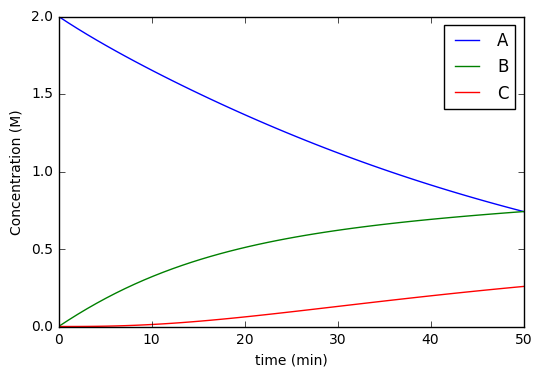

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

NA, NB, V = sol.T

# Equivalent to:
# NA = sol[:, 0]
# NB = sol[:, 1]
# V = sol[:, 2]

Na0 = Ca0 * V0
X = (Na0 - NA) / Na0

#NC = Ca0 * V0 - NA
NC = Na0 * X

plt.plot(tspan, NA/V, tspan, NB/V, tspan, NC / V)
plt.legend(['A', 'B', 'C'])
plt.xlabel('time (min)')
plt.ylabel('Concentration (M)')

$C_A$ will go down simply by dilution! We double the volume, which would cut $C_A$ in half even with no reaction. Initially we had 10 mol of A. Finally we have &asymp; 7.4 mol. The difference is what reacted.

It is clear we could get more product if we let the reactor run longer. Unfortunately at 50 minutes the reactor is full, and if we add anymore reactants it will overflow. What if we run in a way that we add reactant for 50 minutes, and then turn the flow off, so that it acts as a batch reactor.

We will add a mole balance on C directly to compare the difference in how to solve the problem, and we make the volumetric flow time dependent.



(0, 10.5)

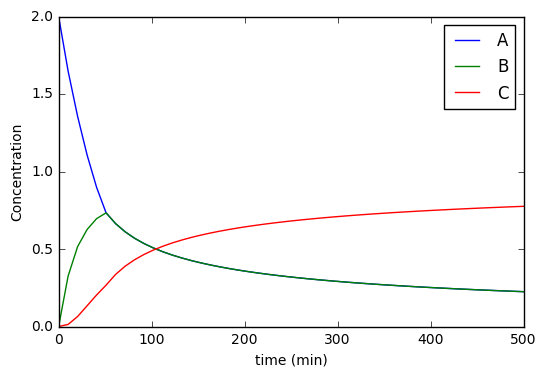

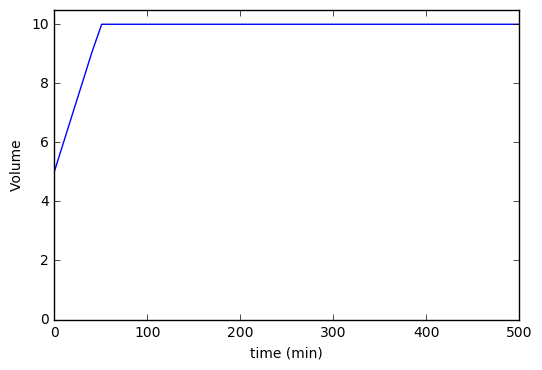

In [17]:
# We have four ODEs
def ode(Y, t):
    Na, Nb, Nc, V = Y

    Ca = Na / V
    Cb = Nb / V
    r = k * Ca * Cb**2

    ra = -r
    rb = -r
    rc = r

    # Time dependent volumetric flow
    if t <=50:
        v = v0
    else:
        v = 0

    dNadt = ra * V
    dNbdt = v * Cbfeed + rb * V
    dNcdt = rc * V
    dVdt = v
    return [dNadt, dNbdt, dNcdt, dVdt]


tspan = np.linspace(0, 500) # minutes
Y0 = [Ca0 * V0, 0.0, 0.0, V0]
sol = odeint(ode, Y0, tspan)

NA, NB, NC, V = sol.T

plt.plot(tspan, NA / V, tspan, NB / V, tspan, NC / V)
plt.legend(['A', 'B', 'C'])
plt.xlabel('time (min)')
plt.ylabel('Concentration')

plt.figure()
plt.plot(tspan, V)
plt.xlabel('time (min)')
plt.ylabel('Volume')
plt.ylim([0, 10.5])

It is always good to check that things worked as expected. Here the volume should have been constant after 50 minutes, and you can see that it is.


# Reactor design with pressure drops

We now consider a generalization of the changing volumetric flow that occurs when the pressure changes. The general form of the volumetric flow is:

$\nu = \nu_0 \frac{F_T}{F_{T0}} \frac{P_0}{P} \frac{T}{T_0} \frac{Z}{Z_0}$

In this equation, $F_T$ is the total molar flow, $P$ is the pressure, $T$ is the temperature, and $Z$ is the compressibility (for ideal gases this is 1). We will stick with isothermal situations for now, so $T = T_0$, but we will consider what happens when the pressure at the exit of the reactor is not the same as the entrance. It is typical for there to be a pressure drop in reactors, and this impacts the volumetric flow, which consequently impacts the concentrations, the reaction rates, and the performance of the reactor. 

With changing pressure we have this equation

$\nu = \nu_0 \frac{F_T}{F_{T0}} \frac{P_0}{P}$

So we have a new variable $P$ and we need a new equation that tells us how the pressure changes. 

The pressure drops in tubular reactors because of viscous, frictional losses in energy. The extent of the pressure drop depends on many factors:

-   gas viscosity
-   gas velocity
-   the area that the gas flows through
-   the diameter of catalyst beads
-   the bulk density of the catalyst
-   the porosity of the bed

One of the most common approaches to modeling the pressure drop is the Ergun equation:

$\frac{dP}{dW} = -\frac{\beta_0}{A_c (1 - \phi) \rho_c}\frac{P_0}{P} \frac{T}{T_0} \frac{F_T}{F_{T0}}$

where:

$\beta_0 = \frac{G (1 - \phi)}{\rho_0 g_c D_p \phi^3}\left [ \frac{150 (1 - \phi) \mu}{D_p} + 1.75 G \right]$

-   $\beta_0$ is a constant that depends only on the properties of the packed bed, and the entrance gas conditions:

<table border="2" cellspacing="0" cellpadding="6" rules="groups" frame="hsides">


<colgroup>
<col  class="org-left" />

<col  class="org-left" />
</colgroup>
<tbody>
<tr>
<td class="org-left">$A_c$</td>
<td class="org-left">bed cross-sectional area</td>
</tr>


<tr>
<td class="org-left">$\rho_c$</td>
<td class="org-left">solid catalyst density</td>
</tr>


<tr>
<td class="org-left">$\phi$</td>
<td class="org-left">catalyst porosity</td>
</tr>


<tr>
<td class="org-left">$\mu$</td>
<td class="org-left">gas viscosity</td>
</tr>


<tr>
<td class="org-left">$G$</td>
<td class="org-left">superficial mass velocity ($\rho u$)</td>
</tr>


<tr>
<td class="org-left">$u$</td>
<td class="org-left">superficial velocity (volumetric flow / $A_c$)</td>
</tr>


<tr>
<td class="org-left">$D_p$</td>
<td class="org-left">catalyst bead diameter</td>
</tr>


<tr>
<td class="org-left">$g_c$</td>
<td class="org-left">32.174 lb$_m$ ft/s$^2$/lb$_f$     (in metric $g_c=1$)</td>
</tr>


<tr>
<td class="org-left">$\rho_0$</td>
<td class="org-left">inlet gas density</td>
</tr>
</tbody>
</table>

Clearly, we need additional data, but the data are all constants. In fact, it is customary to lump additional constants, and to define:

$\alpha = \frac{2 \beta_0}{A_c \rho_c (1 - \phi) P_0}$ and to define $y = P / P_0$ so that we can reexpress the differential equation as:

$\frac{dy}{dW} = -\frac{\alpha}{2 y}\frac{T}{T_0} \frac{F_T}{F_{T0}}$   (this is the important equation to remember)

This leads us to an additional differential equation we must use with one additional parameter $\alpha$ that is required. This parameter tells us how the pressure drops with increasing volume or catalyst mass. You can see the equation is coupled to the mole balances by $F_T$.

This equation depends on $F_T$, so it is coupled to the mole balances. So, we will typically have equations such as:

\begin{align}
\frac{dF_A}{dW} = r_A \\
\frac{dF_B}{dW} = r_B \\
\vdots \\
\frac{dy}{dW} = -\frac{\alpha}{2 y}\frac{T}{T_0} \frac{F_T}{F_{T0}}
\end{align}

which must be numerically integrated with appropriate initial conditions.


## A worked example with a pressure drop and inerts

We consider the partial oxidation of ethylene to ethylene oxide:

$C_{2}H_4 + 0.5 O_2 \rightarrow C_{2}H_{4}O$

Oxygen is fed in a stoichiometric amount in the form of air.

The rate law is given as $-r_A = k P_A^{1/3} P_B^{2/3}$, with  $k = 0.0141$ lb-mol / (atm \* lb\_m cat \* h)

-   A is fed at a rate of $F_{A0}$ = 1.08 lbmol / h
-   B is fed at a rate of $0.5  F_{A0}$
-   $F_{N_2} = F_B  0.8 / 0.2$
-   The feed pressure is 10 atm.
-   &alpha; for the conditions and bed are provided as 0.0166 1 / (lb\_m cat).

Let us estimate the catalyst weight required to achieve 60% conversion of A. Also, plot the volumetric flow, conversion, molar flow of each species, and the pressure drop in the reactor.

We need a mole balance for each species so we can compute the total molar flow rate at any point.

-   We use the total molar flowrate to compute the total pressure
-   We use the mole fraction of each species to compute the species partial pressure for use in the rate law.
-   We use reaction stoichiometry to relate the species rates
-   We need a differential equation on the change in pressure



In [23]:
import numpy as np
from scipy.integrate import odeint

Fa0 = 1.08 # lbmol / h
Fb0 = 0.5 * Fa0
FI0 = Fb0 * 0.8 / 0.2  # flow rate of N2
Fc0 = 0.0

Ft0 = Fa0 + Fb0 + FI0 + Fc0
P0 = 10 # atm

alpha = 0# 0.0166 # 1 / lb_m cat
k = 0.0141 # lb-mol / (atm * lb_m cat * h)

Next we set up the ODE. The rate law is in terms of pressure here, so we need to compute these. The idea is to get the mole fraction of each species, and then multiply that by the total pressure: $P_i = x_i P = F_i / F_T P$.



In [24]:
def ode(F, W):
    Fa, Fb, Fc, y = F  # unpack the variables
    P = y * P0

    Ft = Fa + Fb + Fc + FI0 # do not forget the inerts!

    Pa = Fa / Ft * P
    Pb = Fb / Ft * P

    # the stoichiometry
    ra = -k * Pa**(1.0/3.0) * Pb**(2.0 / 3.0)
    rb = 0.5 * ra
    rc = -ra

    # define the 4 coupled ODES
    dFadW = ra
    dFbdW = rb
    dFcdW = rc
    dydW = -alpha /(2 * y) * Ft / Ft0

    return [dFadW, dFbdW, dFcdW, dydW]

The integration of the ODEs is straight-forward.



In [25]:
# initial conditions
y0 = 1.0 # P/P0
F0 = [Fa0, Fb0, Fc0, y0]

Wspan = np.linspace(0, 60) # lb_m cat

sol = odeint(ode, F0, Wspan)
Fa, Fb, Fc, y = sol.T

Let us look at some details. First, we plot the volumetric flow in the reactor and then the conversion. We do not have the temperature, so we cannot actually determine the inlet volumetric flow, so we instead plot $\nu/\nu_0 = Ft / Ft0 * P0 / P$.



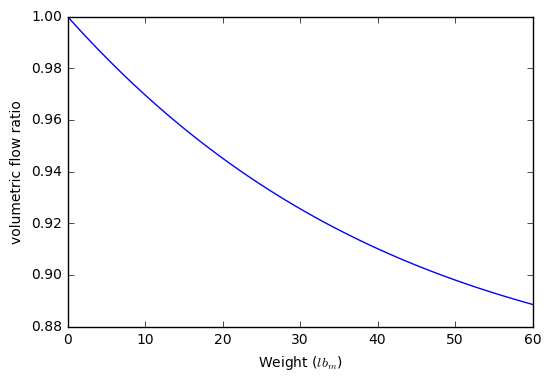

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

P = y * P0
Ft = Fa + Fb + Fc + FI0


nu_ratio = Ft / Ft0 * P0 / P
plt.plot(Wspan, nu_ratio)
plt.xlabel('Weight ($lb_m$)')
plt.ylabel('volumetric flow ratio')

You can see that the volumetric flow is increasing substantially! Next we consider the conversion.



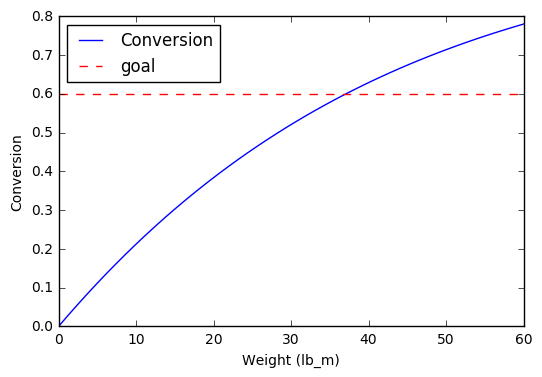

In [27]:
X = (Fa0 - Fa) / Fa0

plt.plot(Wspan, X, [0, 60], [0.6, 0.6], 'r--')
plt.legend(['Conversion', 'goal'], loc='best')
plt.xlabel('Weight (lb_m)')
plt.ylabel('Conversion')

From the conversion graph, we can see the answer is we need about 50 lb of catalyst to get 60% conversion. We can get a more precise answer with interpolation.



In [28]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

f = interp1d(Wspan, X)

def objective(W):
    return f(W) - 0.6

ans, = fsolve(objective, 50)
print('X=0.6 at a catalyst weight of {:1.2f} lb_m'.format(ans))

X=0.6 at a catalyst weight of 37.07 lb_m


If you "invert" the interpolation you can avoid the fsolve. This will not always work, but it does here because inverting the interpolation results in a single-valued function. The interpolation function returns an array, so we have to convert the result to a float for formatting here.



In [29]:
f2 = interp1d(X, Wspan)
print('X=0.6 at a catalyst weight of {:1.2f} lb_m'.format(float(f2(0.6))))

X=0.6 at a catalyst weight of 37.07 lb_m


Finally, we look at the molar flows and pressure drop.



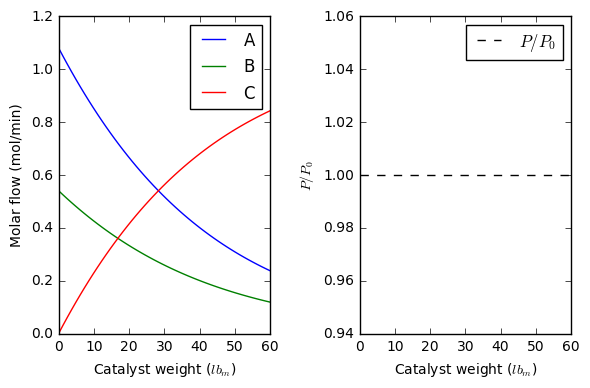

In [30]:
plt.subplot(1, 2, 1) # subplot with two columns in one row
plt.plot(Wspan, Fa, Wspan, Fb, Wspan, Fc)
plt.legend(['A', 'B', 'C'], loc='best')
plt.xlabel('Catalyst weight ($lb_m$)')
plt.ylabel('Molar flow (mol/min)')

plt.subplot(1, 2, 2)
plt.plot(Wspan, y, 'k--') # plot column 3
plt.xlabel('Catalyst weight ($lb_m$)')
plt.ylabel('$P/P_0$')
plt.legend(['$P/P_0$'],loc='upper right')

plt.tight_layout()

-   You can see more than 50% pressure drop over the length of the bed

-   Set $\alpha$ to 0 to see the effect of the pressure drop. Does conversion increase or decrease?

Note that the $y$ will go to zero, and at that point you will have problems solving the equations. This is an unphysical limit and the Ergun equation probably becomes invalid. It is not possible to actually get to a pressure of 0! Also, if the reactor vents to the atmosphere, is not possible to get a pressure less than an atm at the exit. 


# Summary points

Today we focused on scenarios where we have to use molar flows and *not* conversion because the concentrations change for reasons other than reaction. In the case of the semibatch reactor the concentrations change because of dilution, in addition to reaction. In the pressure drop case the concentrations change because of the pressure drop, in addition to the reaction.

We introduced the idea of coupled ODEs, and the use of interpolation in solving some problems with ODEs.

